In [1]:
%%capture
!pip install SimpleITK
# !pip install skan
!pip install git+https://github.com/jni/skan
!pip install tifffile

In [2]:
import SimpleITK as sitk
from skimage.morphology import skeletonize, thin, medial_axis#, skeletonize_3d
from scipy import ndimage
from skan import csr, Skeleton
from skan import summarize
from skan import draw
import tifffile as tiff
import asyncio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import glob
from tqdm.notebook import tnrange
import shutil
from google.colab import files
import os

In [4]:
folder_id = "/content/STEREOM 2 RVE 1/Threshold"
!unzip "/content/STEREOM 2 RVE 1.zip"

Archive:  /content/STEREOM 2 RVE 1.zip
   creating: STEREOM 2 RVE 1/
  inflating: __MACOSX/._STEREOM 2 RVE 1  
   creating: STEREOM 2 RVE 1/Quant3D/
  inflating: __MACOSX/STEREOM 2 RVE 1/._Quant3D  
   creating: STEREOM 2 RVE 1/Threshold/
  inflating: __MACOSX/STEREOM 2 RVE 1/._Threshold  
   creating: STEREOM 2 RVE 1/SEG 3D/
  inflating: __MACOSX/STEREOM 2 RVE 1/._SEG 3D  
  inflating: STEREOM 2 RVE 1/Quant3D/MIL.jpg  
  inflating: __MACOSX/STEREOM 2 RVE 1/Quant3D/._MIL.jpg  
  inflating: STEREOM 2 RVE 1/Quant3D/Stereom 2 RVE 1.txt  
  inflating: __MACOSX/STEREOM 2 RVE 1/Quant3D/._Stereom 2 RVE 1.txt  
  inflating: STEREOM 2 RVE 1/Threshold/Stereom 2 RVE 1-058.tiff  
  inflating: __MACOSX/STEREOM 2 RVE 1/Threshold/._Stereom 2 RVE 1-058.tiff  
  inflating: STEREOM 2 RVE 1/Threshold/Stereom 2 RVE 1-019.tiff  
  inflating: __MACOSX/STEREOM 2 RVE 1/Threshold/._Stereom 2 RVE 1-019.tiff  
  inflating: STEREOM 2 RVE 1/Threshold/Stereom 2 RVE 1-062.tiff  
  inflating: __MACOSX/STEREOM 2 RVE 1

In [12]:
def plot_3d_nodes_and_branches_mpl(df_nodes, df_segments):
    """Plots the 3D nodes and branches using Matplotlib."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(df_nodes['node_coordinate_x'], df_nodes['node_coordinate_y'], df_nodes['node_coordinate_z'], c='red', marker='o', label='Nodes')

    # Plot branches
    for _, row in df_segments.iterrows():
        path = np.array(row['path-coords'])
        ax.plot(path[:, 2], path[:, 1], path[:, 0], color='blue', linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.show()



def plot_3d_nodes_and_branches_plotly(df_nodes, df_segments):
    """
    Plots 3D nodes and branches using Plotly.

    Args:
        df_nodes (pd.DataFrame): DataFrame containing node data.
        df_segments (pd.DataFrame): DataFrame containing segments data.
    """
    fig = go.Figure()

    # Plot nodes
    fig.add_trace(go.Scatter3d(
        x=df_nodes['node_coordinate_x'],
        y=df_nodes['node_coordinate_y'],
        z=df_nodes['node_coordinate_z'],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Nodes'
    ))

    # Plot branches
    for _, row in df_segments.iterrows():
        path = np.array(row['path-coords'])
        if path.shape[1] == 3:  # Ensure correct shape
            fig.add_trace(go.Scatter3d(
                x=path[:, 2], y=path[:, 1], z=path[:, 0],  # Swap coordinates to match nodes
                mode='lines',
                line=dict(color='blue', width=2),
                name='Branches'
            ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Nodes and Branches Visualization'
    )
    fig.show()


def tiffs_to_3d_numpy(folderpath):
    """
    Converts tiff files to a 3D numpy array.

    Args:
        folderpath (str): path to folder containing tiff files.

    Returns:
        np.array: 3D numpy array containing image data.
    """
    filelist = [os.path.join(folderpath, f) for f in os.listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f))]

    # Sort files by numerical order based on filename
    filelist.sort(key=lambda x: int(x[-8:-5]))  # Sort by the 3-digit number in filenames

    sorted_filelist = [f for f in filelist]

    # Read the TIFF images into a numpy array
    return np.array([plt.imread(fname) for fname in sorted_filelist])


def compute_porosity(img):
    """
    Computes porosity as the ratio of black pixels to total pixels.

    Args:
        img (np.array): binary image (0 for black, 1 for white).

    Returns:
        float: Porosity value.
    """
    num_white_pix = np.sum(img == 1)
    num_black_pix = np.sum(img == 0)
    return num_black_pix / (num_white_pix + num_black_pix)


def compute_distance_transform(segmentation_data):
    """
    Computes the 3D distance transform of the segmentation data.

    Args:
        segmentation_data (np.array): 3D binary segmentation data.

    Returns:
        np.array: 3D distance transform of the binary image.
    """
    return ndimage.distance_transform_edt(segmentation_data)


def skeletonize_data(segmentation_data, dist_trans_3d):
    """
    Skeletonizes the binary image and summarizes the skeleton using Skan.

    Args:
        segmentation_data (np.array): Binary image data.
        dist_trans_3d (np.array): 3D distance transform of the binary image.

    Returns:
        pd.DataFrame: DataFrame containing skeleton data.
    """
    skimage_skeleton = skeletonize(segmentation_data, method='lee')
    skan_skeleton = Skeleton(skeleton_image=skimage_skeleton * dist_trans_3d)
    df_skeleton = summarize(skan_skeleton)

    # Rename and scale columns
    df_skeleton.rename(columns={
        'image-coord-src-0': 'src-x',
        'image-coord-src-1': 'src-y',
        'image-coord-src-2': 'src-z',
        'image-coord-dst-0': 'dst-x',
        'image-coord-dst-1': 'dst-y',
        'image-coord-dst-2': 'dst-z',
        'mean-pixel-value': 'thickness'
    }, inplace=True)

    # Scale thickness and distances
    df_skeleton[['thickness', 'branch-distance', 'euclidean-distance']] *= (2 * 1.485)

    # Drop unnecessary columns
    df_skeleton.drop(columns=['stdev-pixel-value', 'coord-src-0', 'coord-src-1', 'coord-src-2', 'coord-dst-0', 'coord-dst-2', 'coord-dst-1'], inplace=True)

    return df_skeleton


def compute_branch_coordinates(df_skeleton, skan_skeleton):
    """
    Computes the 3D path coordinates for branches in the skeleton.

    Args:
        df_skeleton (pd.DataFrame): DataFrame containing skeleton data.
        skan_skeleton (Skeleton): Skan skeleton object.

    Returns:
        pd.DataFrame: Updated DataFrame with path coordinates.
    """
    branch_path_coords = [np.array(skan_skeleton.path_coordinates(i))[:, [2, 1, 0]].tolist() for i in range(len(df_skeleton))]
    df_skeleton['path-coords'] = branch_path_coords

    return df_skeleton


def compute_segments(df_skeleton):
    """
    Computes segment data based on skeleton and path coordinates.

    Args:
        df_skeleton (pd.DataFrame): DataFrame containing skeleton data.

    Returns:
        pd.DataFrame: DataFrame containing segments data.
    """
    segments = df_skeleton[['thickness', 'branch-distance', 'euclidean-distance', 'path-coords']].copy()
    segments['source_node_id'] = df_skeleton['node-id-src']
    segments['destination_node_id'] = df_skeleton['node-id-dst']
    segments['tortuosity'] = segments['branch-distance'] / segments['euclidean-distance']
    segments.loc[segments['path-coords'].apply(lambda x: x[0] == x[-1]), 'tortuosity'] = -1

    return segments


def compute_node_coordinates(df_skeleton):
    """
    Computes final node coordinates from skeleton data.

    Args:
        df_skeleton (pd.DataFrame): DataFrame containing skeleton data.

    Returns:
        pd.DataFrame: DataFrame containing unique node coordinates.
    """
    final_nodes = pd.concat([
        df_skeleton[['node-id-src', 'src-x', 'src-y', 'src-z']].rename(columns={'node-id-src': 'node_id', 'src-x': 'node_coordinate_x', 'src-y': 'node_coordinate_y', 'src-z': 'node_coordinate_z'}),
        df_skeleton[['node-id-dst', 'dst-x', 'dst-y', 'dst-z']].rename(columns={'node-id-dst': 'node_id', 'dst-x': 'node_coordinate_x', 'dst-y': 'node_coordinate_y', 'dst-z': 'node_coordinate_z'})
    ], ignore_index=True).drop_duplicates().reset_index(drop=True)

    return final_nodes

Porosity = 56.88%


<ipython-input-13-edc3c1bea56a>:63: VisibleDeprecationWarning:

separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.



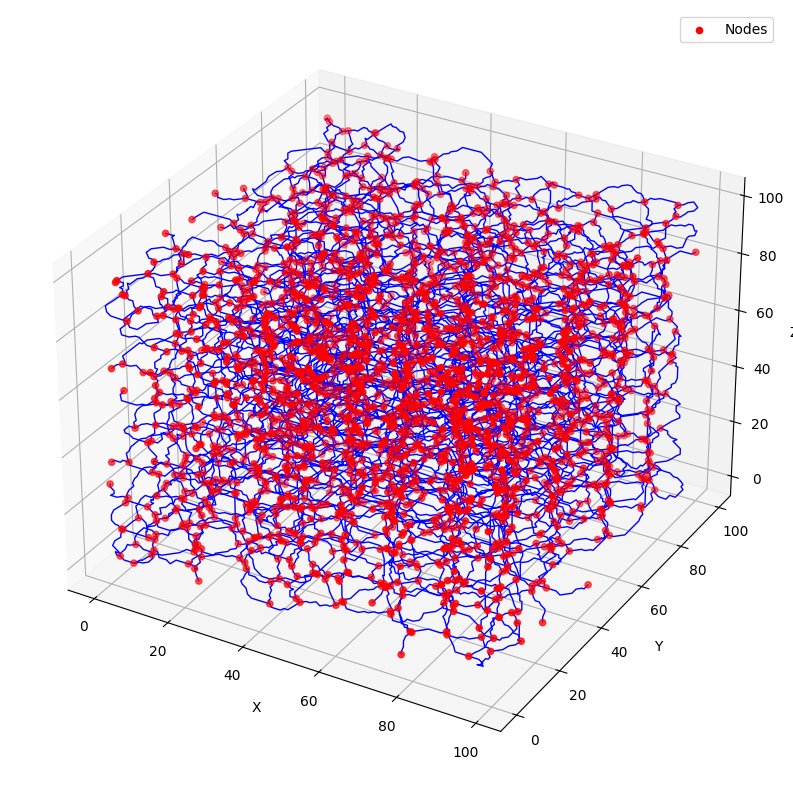

Average Thickness: 8.110
Average Branch Distance: 19.345
Average Euclidean Distance: 16.824


In [13]:
# Process TIFF images
segmentation_data_np = tiffs_to_3d_numpy(folder_id)
porosity = compute_porosity(segmentation_data_np)
print(f"Porosity = {porosity * 100:.2f}%")

# Compute distance transform
dist_trans_3d = compute_distance_transform(segmentation_data_np)

# Skeletonize data
df_skeleton = skeletonize_data(segmentation_data_np, dist_trans_3d)

# Compute branch coordinates
df_skeleton = compute_branch_coordinates(df_skeleton, Skeleton(skeleton_image=skeletonize(segmentation_data_np, method='lee') * dist_trans_3d))

# Compute segments
segments = compute_segments(df_skeleton)

# Save segments to CSV
segments.to_csv(folder_id + "_segments.csv", index=False)

# Compute node coordinates
final_nodes_3d = compute_node_coordinates(df_skeleton)

# Save nodes to CSV
final_nodes_3d.to_csv(folder_id + "_nodes.csv", index=False)

# Plot nodes and branches
plot_3d_nodes_and_branches_mpl(final_nodes_3d, segments)


avg_thickness = df_3d['thickness'].mean()
avg_branch_distance = df_3d['branch-distance'].mean()
avg_euclidean_distance = df_3d['euclidean-distance'].mean()

print(f"Average Thickness: {avg_thickness:.3f}")
print(f"Average Branch Distance: {avg_branch_distance:.3f}")
print(f"Average Euclidean Distance: {avg_euclidean_distance:.3f}")


In [10]:
# might take some time
# plot_3d_nodes_and_branches_plotly(final_nodes_3d, segments)

In [15]:
# # /content/Thresholds/Threshold model 1/ nodes.csv
# files.download(folder_id+"_nodes.csv")
# files.download(folder_id+"_segments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>